# Assignment
- Continue to participate in the [Kaggle Caterpillar competition](https://www.kaggle.com/c/caterpillar-tube-pricing).
- Do more feature engineering. 
- Use xgboost for gradient boosting.
- Submit new predictions.
- Commit your notebook to your fork of the GitHub repo.

## Stretch Goals
- Improve your scores on Kaggle.
- Make visualizations and share on Slack.
- Look at [Kaggle Kernels](https://www.kaggle.com/c/caterpillar-tube-pricing/kernels) for ideas about feature engineerng and visualization.
- Look at the bonus notebook in the repo, about Monotonic Constraints with Gradient Boosting.
- Read more about gradient boosting:
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - [A Kaggle Master Explains Gradient Boosting](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/)
  - [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf) Chapter 8
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)
  - [Boosting](https://www.youtube.com/watch?v=GM3CDQfQ4sw) (3 minute video)

In [0]:
!wget https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/caterpillar/caterpillar-tube-pricing.zip

In [81]:
!unzip caterpillar-tube-pricing.zip

Archive:  caterpillar-tube-pricing.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: sample_submission.csv   
  inflating: data.zip                


In [0]:
!unzip data.zip

In [0]:
!pip install category_encoders

In [0]:
!pip install -U pandas-profiling

## Feature engineering

In [0]:
import category_encoders as ce
import pandas as pd
import numpy as np
import pandas_profiling
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

SOURCE = 'competition_data/'

In [86]:
from glob import glob

data = {}
for path in glob(SOURCE + '*.csv'):
    df = pd.read_csv(path)
    filename = path.split('/')[-1]
    name = filename.split('.')[0]
    data[name] = df
data.keys()

dict_keys(['type_end_form', 'comp_elbow', 'tube_end_form', 'type_connection', 'comp_adaptor', 'bill_of_materials', 'comp_sleeve', 'comp_straight', 'comp_hfl', 'components', 'comp_float', 'comp_threaded', 'test_set', 'comp_nut', 'tube', 'train_set', 'specs', 'comp_other', 'type_component', 'comp_boss', 'comp_tee'])

In [0]:
type_component['name'].values

In [0]:
type_component = data['type_component']
type_component['name_len'] = len(type_component['name'].values)type_component.apply(lambda row: forming(row), axis=1)
type_component

In [29]:
data['components'].sample(1)

component_id      name component_type_id
2012       C-2012  COUPLING             OTHER

In [0]:
# shows whether end_x and end_a are the same or not
def forming(row):
  if (row['forming_a'] == 'No') & (row['forming_x'] == 'No'):
    return 'both_no'
  if (row['forming_a'] == 'Yes') & (row['forming_x'] == 'Yes'):
    return 'both_yes'
  if (row['forming_a'] == 'No') & (row['forming_x'] == 'Yes'):
    return 'a_no_x_yes'
  if (row['forming_a'] == 'Yes') & (row['forming_x'] == 'No'):
    return 'a_yes_x_no'

In [0]:
def wrangle(X):
    X = X.copy()
    
    # Engineer date features
    X['quote_date'] = pd.to_datetime(X['quote_date'], infer_datetime_format=True)
    X['quote_date_year'] = X['quote_date'].dt.year
    X['quote_date_month'] = X['quote_date'].dt.month
    X = X.drop(columns='quote_date')
    
    # Merge tube data
    tube = pd.read_csv(SOURCE + 'tube.csv')
    X = X.merge(tube, how='left')
    
    # Engineer features from bill_of_materials
    materials = pd.read_csv(SOURCE + 'bill_of_materials.csv')
    
    materials['components_total'] = (materials['quantity_1'].fillna(0) + 
                                     materials['quantity_2'].fillna(0) + 
                                     materials['quantity_3'].fillna(0) + 
                                     materials['quantity_4'].fillna(0) + 
                                     materials['quantity_5'].fillna(0) + 
                                     materials['quantity_6'].fillna(0) + 
                                     materials['quantity_7'].fillna(0) + 
                                     materials['quantity_8'].fillna(0))

    materials['components_distinct'] = (materials['component_id_1'].notnull().astype(int) + 
                                        materials['component_id_2'].notnull().astype(int) + 
                                        materials['component_id_3'].notnull().astype(int) + 
                                        materials['component_id_4'].notnull().astype(int) + 
                                        materials['component_id_5'].notnull().astype(int) + 
                                        materials['component_id_6'].notnull().astype(int) + 
                                        materials['component_id_7'].notnull().astype(int) + 
                                        materials['component_id_8'].notnull().astype(int))
    
    # Merge selected features from bill_of_materials
    # Just use the first component_id, ignore the others for now!
    features = ['tube_assembly_id', 'component_id_1', 'components_total', 'components_distinct']
    X = X.merge(materials[features], how='left')
    
    # Get component_type_id (has lower cardinality than component_id)
    components = pd.read_csv(SOURCE + 'components.csv')
    components = components.rename(columns={'component_id': 'component_id_1'})
    features = ['component_id_1', 'component_type_id']
    X = X.merge(components[features], how='left')
    
    # Count the number of specs for the tube assembly
    specs = pd.read_csv(SOURCE + 'specs.csv')
    specs['specs_total'] = specs.drop(columns=['tube_assembly_id']).count(axis=1)
    features = ['tube_assembly_id', 'specs_total', 'spec1']
    X = X.merge(specs[features], how='left')
    
    # Check tube_end_form results
    tube_end_form = pd.read_csv(SOURCE + 'tube_end_form.csv')
    tube_end_a = tube_end_form.rename(columns={'end_form_id': 'end_a', 'forming': 'forming_a'})
    features = ['end_a', 'forming_a']
    X = X.merge(tube_end_a[features], how='left')
    tube_end_x = tube_end_form.rename(columns={'end_form_id': 'end_x', 'forming': 'forming_x'})
    features = ['end_x', 'forming_x']
    X = X.merge(tube_end_x[features], how='left')
    # check whether forming_a and forming_x are the same or not
    X['forming'] = X.apply(lambda row: forming(row), axis=1)
    
    # Type_component
    
    # Drop tube_assembly_id because our goal is to predict unknown assemblies
    X = X.drop(columns='tube_assembly_id')
    
    # Drop low importance features
#     X = X.drop(columns=['num_bracket'])
    
    return X

In [0]:
# Read data
trainval = pd.read_csv(SOURCE + 'train_set.csv')
test = pd.read_csv(SOURCE + 'test_set.csv')

# Split into train & validation sets
# All rows for a given tube_assembly_id should go in either train or validation
trainval_tube_assemblies = trainval['tube_assembly_id'].unique()
train_tube_assemblies, val_tube_assemblies = train_test_split(
    trainval_tube_assemblies, random_state=42)
train = trainval[trainval.tube_assembly_id.isin(train_tube_assemblies)]
val = trainval[trainval.tube_assembly_id.isin(val_tube_assemblies)]

# Wrangle train, validation, and test sets
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

# Arrange X matrix and y vector (log-transformed)
target = 'cost'
X_train = train.drop(columns=target)
X_val = val.drop(columns=target)
X_test = test.drop(columns='id')
y_train = train[target]
y_val = val[target]
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

In [55]:
train.sample(1)

supplier  annual_usage  min_order_quantity  ... forming_a  forming_x  forming
7733   S-0066             0                   0  ...       Yes        Yes      Yes

[1 rows x 32 columns]

In [34]:
train.profile_report()

In [60]:
%%time
# Make pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit
pipeline.fit(X_train, y_train_log)

# Validate
y_pred_log = pipeline.predict(X_val)
print('Validation Error', rmse(y_val_log, y_pred_log))

Validation Error 0.2949750183622853
CPU times: user 20.5 s, sys: 39.9 ms, total: 20.6 s
Wall time: 10.6 s


In [94]:
%%time
# Make pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(n_estimators=648, random_state=42, n_jobs=-1)
)

# Fit
pipeline.fit(X_train, y_train_log)

# Validate
y_pred_log = pipeline.predict(X_val)
print('Validation Error', rmse(y_val_log, y_pred_log))

[06:25:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation Error 0.27580209507625136
CPU times: user 19.3 s, sys: 30.1 ms, total: 19.3 s
Wall time: 9.83 s


In [90]:
%%time
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

eval_set = [(X_train_encoded, y_train_log), 
            (X_val_encoded, y_val_log)]

model = XGBRegressor(n_estimators=1000, n_jobs=-1)
model.fit(X_train_encoded, y_train_log, 
          early_stopping_rounds=10, eval_metric='rmse', 
          eval_set=eval_set)

[06:20:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.71924	validation_1-rmse:1.70846
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.56516	validation_1-rmse:1.55498
[2]	validation_0-rmse:1.42779	validation_1-rmse:1.41846
[3]	validation_0-rmse:1.30337	validation_1-rmse:1.2943
[4]	validation_0-rmse:1.19168	validation_1-rmse:1.18291
[5]	validation_0-rmse:1.09316	validation_1-rmse:1.08542
[6]	validation_0-rmse:1.00527	validation_1-rmse:0.998172
[7]	validation_0-rmse:0.928401	validation_1-rmse:0.924139
[8]	validation_0-rmse:0.85995	validation_1-rmse:0.856456
[9]	validation_0-rmse:0.798442	validation_1-rmse:0.795475
[10]	validation_0-rmse:0.745619	validation_1-rmse:0.745052
[11]	validation_0-rmse:0.698429	validation_1-rmse:0.697991
[12]	validation_0-rmse:0.658137

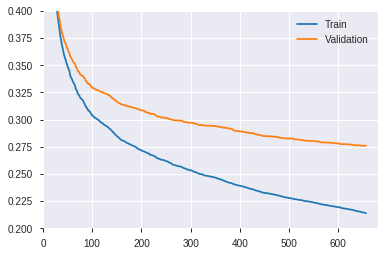

In [92]:
results = model.evals_result()
train_rmse = results['validation_0']['rmse']
val_rmse = results['validation_1']['rmse']
epoch = range(len(train_rmse))
plt.plot(epoch, train_rmse, label='Train')
plt.plot(epoch, val_rmse, label='Validation')
plt.ylim((0.2,0.4))
plt.xlim((0,680))
plt.legend();

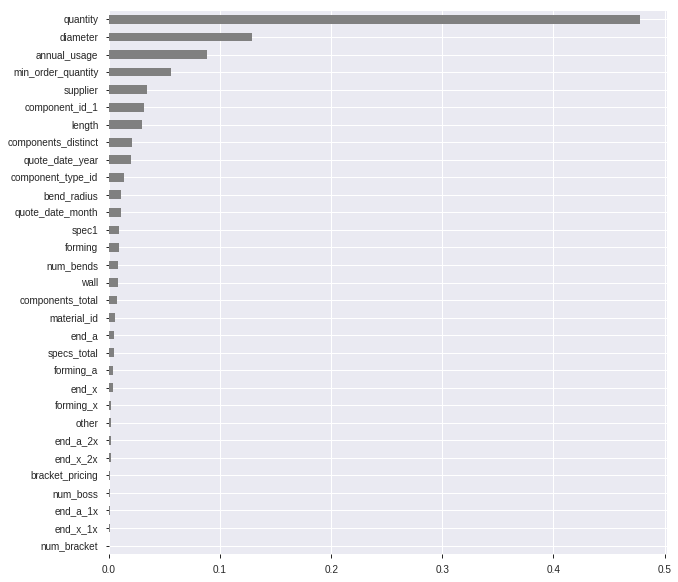

In [57]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
rf = pipeline.named_steps['randomforestregressor']
importances = pd.Series(rf.feature_importances_, X_train.columns)
importances.sort_values().plot.barh(color='grey');

### Kaggle RMSLE: 0.275802

In [0]:
# Predict
def generate_submission(estimator, X_test, filename):
    y_pred_log = estimator.predict(X_test)
    y_pred = np.expm1(y_pred_log)  # Convert from log-dollars to dollars
    submission = pd.read_csv(SOURCE + '../sample_submission.csv')
    submission['cost'] = y_pred
    submission.to_csv(filename, index=False)
    
generate_submission(pipeline, X_test, 'submission-03.csv')

In [91]:
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)  # Convert from log-dollars to dollars
submission = pd.read_csv(SOURCE + '../sample_submission.csv')
submission['cost'] = y_pred
submission.to_csv('submission-03.csv', index=False)

ValueError: ignored